In [1]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy import constants as const
from astropy import units as u
from scipy.interpolate import splrep,splev
from scipy import interpolate 
from scipy import signal
import scipy.integrate as it
from scipy.interpolate import interp1d

c = 299792

import matplotlib as mpl

mpl.rc('figure',
       titlesize=24,
       figsize=(12,10),
      dpi=250,
      edgecolor='black',
    facecolor='white'
      )

mpl.rcParams['font.family'] = 'Arial' # 'sans-serif' , 'cursive' , 'fantasy','monospace' (e.g., Courier)

mpl.rc('lines',
       linewidth=2,
       color='r',
      linestyle='-',
      markersize=6,
      dash_joinstyle='miter', # miter/round/bevel
      dash_capstyle='butt',  #butt/round/projecting
      solid_joinstyle='miter',
      solid_capstyle='projecting',
      dashed_pattern= (2.8, 1.2),
       dashdot_pattern= (4.8, 1.2, 0.8, 1.2),
       dotted_pattern = (1.1, 1.1),
       scale_dashes = True
      )

mpl.rc('legend',
      fancybox=True, # if True, use a rounded box for the
      numpoints=1, # the number of marker points in the legend line
      markerscale =1,
      fontsize = 'medium',
      borderaxespad = 0.5) # the border between the axes and legend edge
             
mpl.rc('axes',
      facecolor='white',
      edgecolor='black',
      linewidth=1.9,
      grid=False,
      titlesize='large',
      labelsize='large',
      labelcolor='black',
      axisbelow='False') #draw axis gridlines and ticks below, patches (True); above patches but below, lines ('line'); or above all (False) 

mpl.rc('grid',
        color= 'lightgray',
       linestyle=':',
       linewidth=.6,
       alpha=.8)

mpl.rc('xtick',
      top=True, 
      bottom=True, 
      color ='k',
      labelsize = 'medium',
      direction = 'in') 

mpl.rc('xtick.major',
      size=5,
      width=2,
      pad=3.5,
      top=True,
      bottom=True)

mpl.rc('xtick.minor',
      size=5,
      width=2,
      pad=3.4,
      top=True,
      bottom=True)

mpl.rc('ytick',
      right=False, 
      left=True, 
      color ='k',
      labelsize = 'medium',
      direction = 'in') 

mpl.rc('ytick.major',
      size=5,
      width=2,
      pad=3.5,
      left=True,
      right=True)

mpl.rc('ytick.minor',
      size=5,
      width=2,
      pad=3.4,
      left=True,
      right=True)

In [2]:
def cc(file1, file2, max_v=10):
    # Load in the Different Spectra
    wavelength1, flux1 = np.loadtxt(file1, unpack=True)
    wavelength2, flux2 = np.loadtxt(file2, unpack=True)
    
    # Get the correlation
    corr_raw = signal.correlate(flux1, flux2, mode='same')
    corr = [float(i)/sum(corr_raw) for i in corr_raw]
    
    # Do the Doppler Shift off of the central value
    shift = [(((wavelength1[len(wavelength1) // 2] - val) * c) / val) for val in wavelength1]
        
    # Interp the function
    f = interp1d(shift, corr, kind='cubic')
    x = np.linspace(-max_v, max_v, num=500)
    y = f(x)

    return x, y

def interp_x_y(x_input, y_input, max_v):
    f8 = interp1d(x_input, y_input / max(y_input), kind='cubic')
    x_new = np.linspace(-max_v, max_v, num=2500)
    y_new = f8(x_new)
    return x_new, y_new

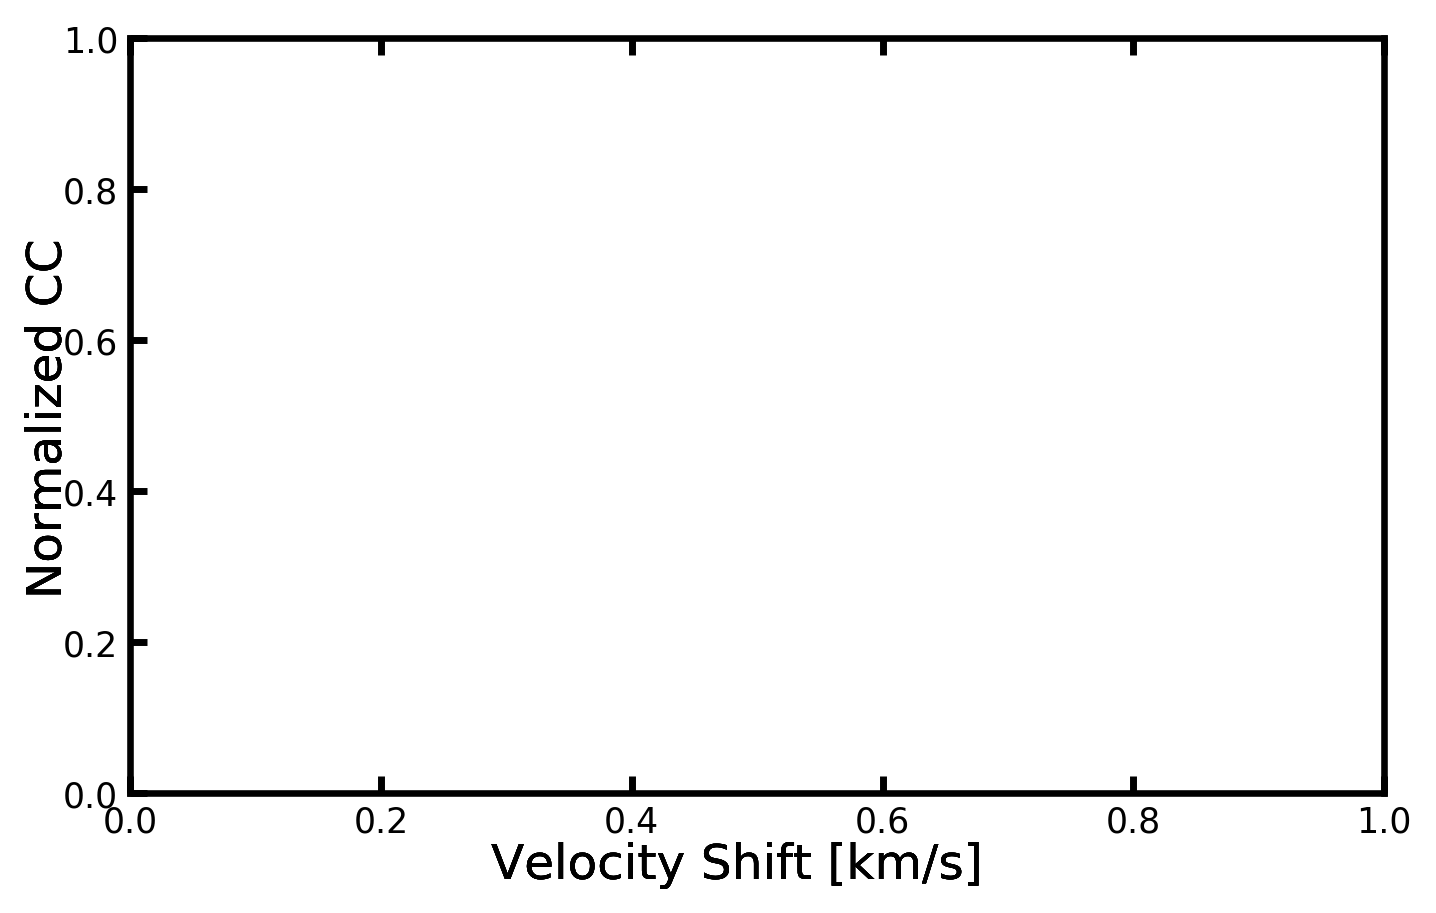

In [19]:
models = ['UPS-LOW-G-CLEAR-250', 'UPS-BIG-G-CLEAR-250', 'UPS-LOW-G-COM-CLOUDY-250', 'UPS-LOW-G-EXT-CLOUDY-250']
model = models[3]

golden_ratio = 1.618

fig, ax = plt.subplots(1, sharex=True, sharey=True,
                      figsize=(4 * golden_ratio, 4), gridspec_kw={'hspace': 0.15, 'wspace': 0.10})

val = 200
base = '/home/imalsky/Desktop/SPECTRA/'

inclinations = [0.0, 0.3925, 0.79, 1.1775, 1.57]
phases = [0.0, 60.0, 120.0, 180.0, 240.0, 300.0]


colors = plt.cm.plasma(np.linspace(0, 0.9, len(phases)))

test_dictionary = {}


for inc in inclinations:
    inc = str(inc)
    test_dictionary[inc] = []
    
    i = 0
    for phase in phases:
        phase = str(phase)

        file1 = base + 'Spec_0_{}_phase_{}_inc_{}000.00.dat'.format(model, phase, inc)
        file2 = base + 'Spec_1_{}_phase_{}_inc_{}000.00.dat'.format(model, phase, inc)

        w1, f1 = np.loadtxt(file1, unpack=True)
        w2, f2 = np.loadtxt(file2, unpack=True)

        # Get the cross correlation
        rv2, cc2 = pyasl.crosscorrRV(w2, f2, w1, f1, -15., 15., 0.5, skipedge=val)

        # Interpolate with a cubic
        x2, y2 = interp_x_y(rv2, cc2, 7.5)

        # The normalized cross correlation
        y2 = np.asarray([(i - min(y2)) / (max(y2) - min(y2)) for i in y2])

        # Save the stuff
        test_dictionary[inc].append(x2[np.argmax(y2)])

        # Plot the stuff
        ax.plot(x2, y2 + i, color=colors[i], linestyle='solid', linewidth=1.0, label='Winds and Rotation')

        # Plot the maximums
        ax.plot(x2[np.argmax(y2)], np.max(y2) + i, 'k.')

        i = i + 1


    ax.axvline(linewidth=1, color='k',linestyle='dashed')
    ax.set_title('Inclination: ' + inc)

    ax.set_xlim(-5, 5)
    #ax.set_ylim(-5, 5)

    #ax.legend(loc='lower right')
    fig.text(0.5, 0.04, 'Velocity Shift [km/s]', ha='center', fontsize=14)
    fig.text(0.06, 0.5, 'Normalized CC', va='center', rotation='vertical', fontsize=14)
    fig.savefig('/home/imalsky/Desktop/Figures-12-18/CC-{}-{}.png'.format(model, inc), dpi=250, bbox_inches='tight')
    plt.cla()



0.0
0.3925
0.79
1.1775
1.57


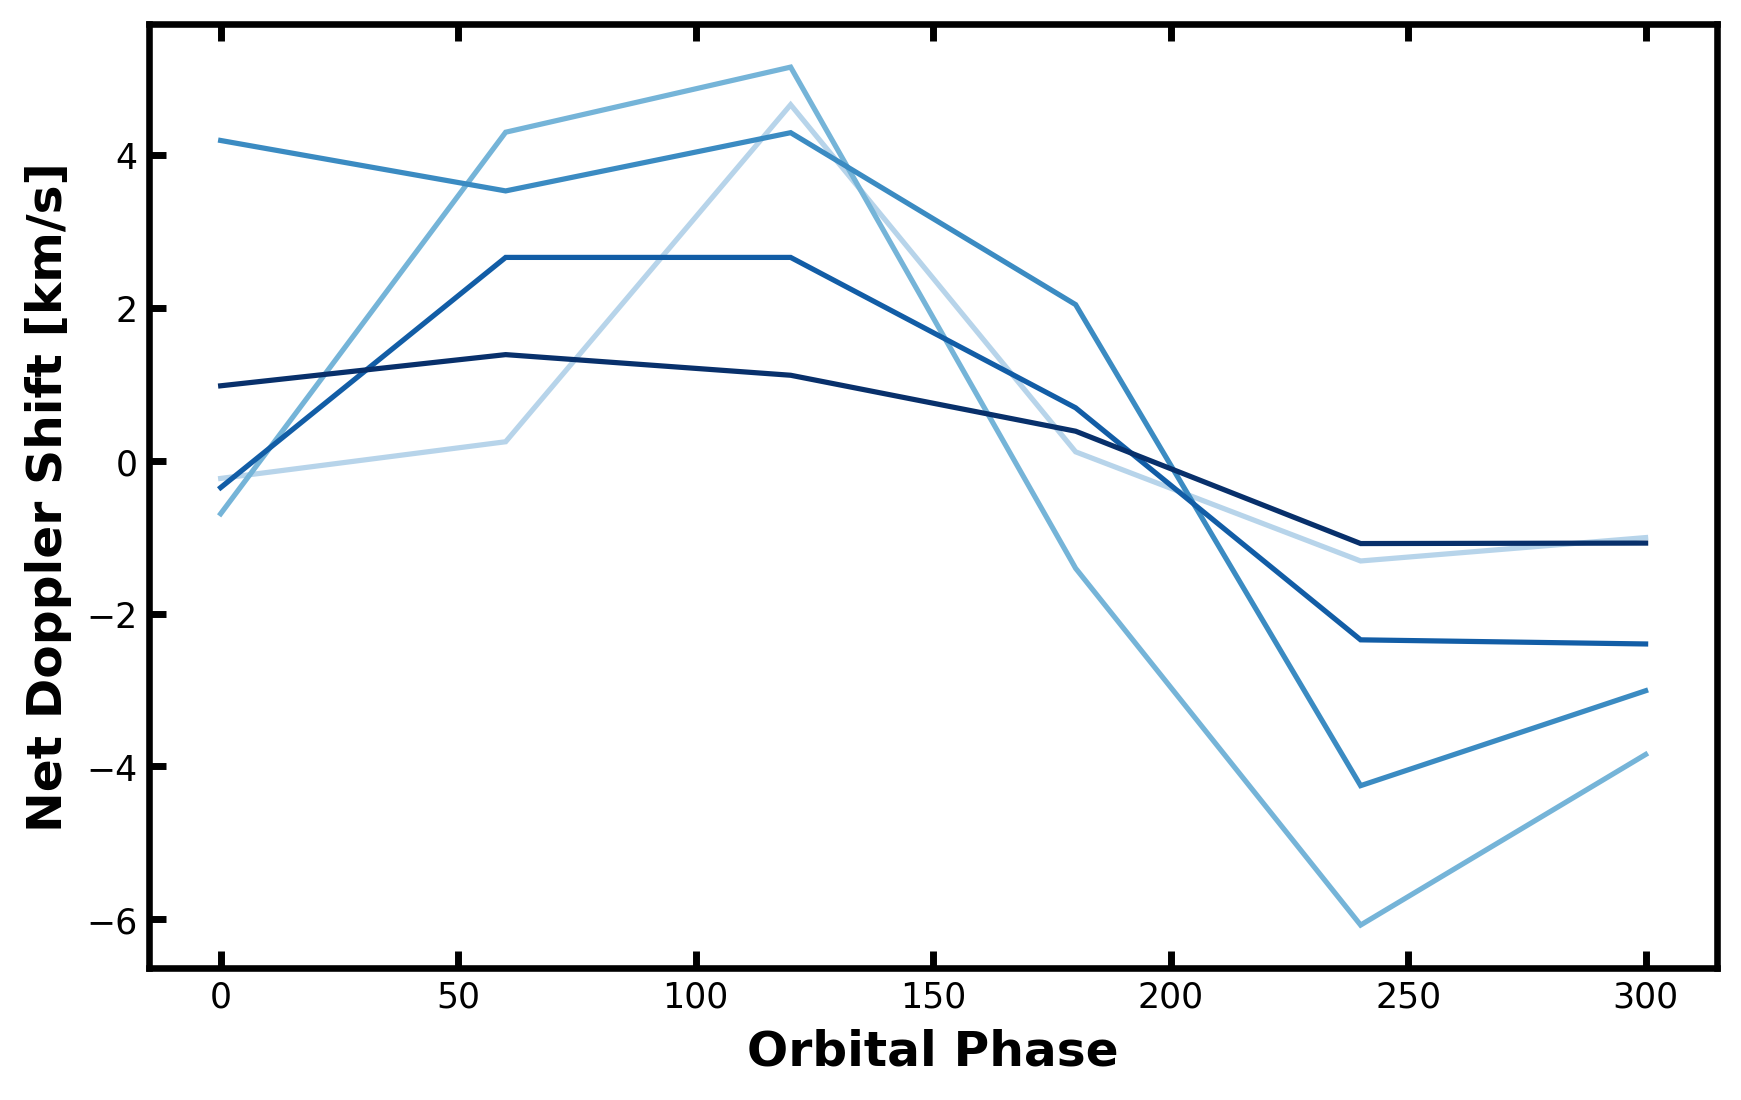

In [20]:

fig, ax = plt.subplots(1, sharex=True, sharey=True,
                       figsize=(5 * golden_ratio, 5), gridspec_kw={'hspace': 0.15, 'wspace': 0.10})
from scipy.interpolate import interp1d

phases = [0.0, 60.0, 120.0, 180.0, 240.0, 300.0]

colors = plt.cm.Blues(np.linspace(.3, 1, len(test_dictionary)))


i = 0
for key in test_dictionary:
    print (key)
    inclination = str(90 - (22.5 * i))
    
    func_test = interp1d(phases, test_dictionary[key], kind='cubic')
    new_x = np.linspace(0, 300, 100)
    
    #ax.plot(new_x, func_test(new_x), color=colors[i], linestyle='solid', 
    #        linewidth=1.5, label=r'Inc: ' + inclination[:4] + '$^{\circ}$')
    
    ax.plot(phases, test_dictionary[key], color=colors[i], linestyle='solid', 
            linewidth=1.5, label=r'Inc: ' + inclination[:4] + '$^{\circ}$')
    
    i = i + 1

ax.set_ylabel('Net Doppler Shift [km/s]', fontsize=14, weight='bold')
ax.set_xlabel('Orbital Phase', fontsize=14, weight='bold')
#ax.legend()
fig.savefig('/home/imalsky/Desktop/Figures-12-18/Net-Shift-{}.png'.format(model), dpi=250, bbox_inches='tight')

In [31]:
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True,
                      figsize=(12, 12), gridspec_kw={'hspace': 0.15, 'wspace': 0.10})

val = 200
base = '/home/imalsky/Desktop/SPECTRA/'

inclinations = [0.0, 0.79, 1.57]
phases = [0.0, 60.0, 120.0, 180.0, 240.0, 300.0]

colors = plt.cm.plasma(np.linspace(0, 0.9, len(phases)))

test_dictionary = {}

j = 0
k = 0
for inc in inclinations:
    print ('On this inclination:', inc)
    inc = str(inc)
    
    test_dictionary[inc] = []
    
    
    i = 0
    
    if j > 4:
        k = 1
        j = 0
    
    for phase in phases:
        #phase = phase + 180
        if phase >= 360:
            phase = phase - 360

        phase = str(phase)

        file1 = base + 'Spec_0_UPS-BIG-G-CLEAR-250_phase_{}_inc_{}000.00.dat'.format(phase, inc)
        file2 = base + 'Spec_0_UPS-BIG-G-CLEAR-250_phase_{}_inc_{}000.00.dat''.format(phase, inc)
        #file3 = base + 'Exo_UpAndB_high_g_2_Final_UpAndB_high_g_phase_{}_inc_{}000.00.dat'.format(phase, inc)
        #file4 = base + 'Exo_UpAndB_high_g_3_Final_UpAndB_high_g_phase_{}_inc_{}000.00.dat'.format(phase, inc)

        w1, f1 = np.loadtxt(file1, unpack=True)
        w2, f2 = np.loadtxt(file2, unpack=True)
        #w3, f3 = np.loadtxt(file3, unpack=True)
        #w4, f4 = np.loadtxt(file4, unpack=True)

        rv1, cc1 = pyasl.crosscorrRV(w1, f1, w1, f1, -15., 15., 1, skipedge=val)
        rv2, cc2 = pyasl.crosscorrRV(w2, f2, w1, f1, -15., 15., 1, skipedge=val)
        #rv3, cc3 = pyasl.crosscorrRV(w3, f3, w1, f1, -15., 15., 1, skipedge=val)
        #rv4, cc4 = pyasl.crosscorrRV(w4, f4, w1, f1, -15., 15., 1, skipedge=val)

        x1, y1 = interp_x_y(rv1, cc1, 7.5)
        x2, y2 = interp_x_y(rv2, cc2, 7.5)
        #x3, y3 = interp_x_y(rv3, cc3, 7.5)
        #4, y4 = interp_x_y(rv4, cc4, 7.5)
        
        y1 = np.asarray([(i - min(y1)) / (max(y1) - min(y1)) for i in y1])
        y2 = np.asarray([(i - min(y2)) / (max(y2) - min(y2)) for i in y2])
        #y3 = np.asarray([(i - min(y3)) / (max(y3) - min(y3)) for i in y3])
        #y4 = np.asarray([(i - min(y4)) / (max(y4) - min(y4)) for i in y4])

        
        #f = open("/home/imalsky/Desktop/test.txt", "a")
        #f.write('phase: ' + str(phase) + ' inc: ' + str(inc)    + '\n')
        #f.write('No Doppler:         ' + str(np.round(x1[np.argmax(y1)], 2)) + '\n')
        #f.write('Winds and Rotation: ' + str(np.round(x2[np.argmax(y2)], 2)) + '\n')
        #f.write('Winds:              ' + str(np.round(x3[np.argmax(y3)], 2)) + '\n')
        #f.write('Rotation:           ' + str(np.round(x4[np.argmax(y4)], 2)) + '\n')
        #f.write('\n')
        #f.close()
        
        test_dictionary[inc].append(x2[np.argmax(y2)])
        
        
        if k == 0 and j == 0 and i == 0:
            ax[k,j].plot(x1, y1 + i, color=colors[i], linestyle='solid', linewidth=1.5, label='No Doppler Shifts')
            ax[k,j].plot(x2, y2 + i, color=colors[i], linestyle='dotted', linewidth=1.5, label='Winds and Rotation')
            #ax[k,j].plot(x3, y3 + i, color=colors[i], linestyle='dashed', linewidth=1.5, label='Winds Only')
            #ax[k,j].plot(x4, y4 + i, color=colors[i], linestyle='dashdot', linewidth=1.5, label='Rotation Only')
        else:
            ax[k,j].plot(x1, y1 + i, color=colors[i], linestyle='solid', linewidth=1.5)
            ax[k,j].plot(x2, y2 + i, color=colors[i], linestyle='dotted', linewidth=1.5)
            #ax[k,j].plot(x3, y3 + i, color=colors[i], linestyle='dashed', linewidth=1.5)
            #ax[k,j].plot(x4, y4 + i, color=colors[i], linestyle='dashdot', linewidth=1.5)

        i = i + 1
        
    ax[k,j].axvline(linewidth=1, color='k',linestyle='dashed')
    #temp_str = str(np.round((k + 1) * j * 0.3, 2))
    ax[k,j].set_title('Inclination: ' + inc)
    j = j + 1
    

ax[0, 0].legend(loc='lower right')
fig.text(0.5, 0.07, 'Velocity Shift [km/s]', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'Normalized Cross Correlation', va='center', rotation='vertical', fontsize=16)
fig.savefig('/home/imalsky/Desktop/blah.pdf', dpi=250, bbox_inches='tight')

print (test_dictionary)


SyntaxError: EOL while scanning string literal (<ipython-input-31-b9d8e11a4ca8>, line 37)

In [57]:
test_dictionary ={'0.0': [-0.7112845138055217, -0.8253301320528212, -0.8913565426170464, -0.8673469387755102, -0.7893157262905159, -0.6752701080432173, -0.5552220888355341, -0.38115246098439304, -0.1710684273709484, 0.04501800720288163, 0.28511404561824794, 0.555222088835535, 0.8313325330132049, 1.059423769507804, 1.2034813925570234, 1.251500600240096, 1.1734693877551017, 0.8433373349339739, 0.2370948379351745, -0.15906362545017938, -0.35114045618247314, -0.435174069627851, -0.48319327731092443, -0.5792316926770704],
                  '0.175': [-0.6872749099639854, -0.7953181272509005, -0.8493397358943575, -0.8313325330132049, -0.7653061224489797, -0.6632653061224483, -0.543217286914766, -0.38115246098439304, -0.18307322929171654, 0.03301320528211349, 0.26110444177671077, 0.5252100840336134, 0.7953181272509013, 1.0234093637454986, 1.179471788715487, 1.2454981992797123, 1.1734693877551017, 0.8613445378151265, 0.25510204081632715, -0.15906362545017938, -0.35714285714285676, -0.4411764705882346, -0.5012004801920762, -0.5912364945978386],
                  '0.349': [-0.6512605042016801, -0.7232893157262898, -0.7653061224489797, -0.7593037214885952, -0.7112845138055217, -0.6272509003601439, -0.5252100840336134, -0.38715486194477755, -0.2010804321728692, -0.0030012004801918124, 0.21308523409363733, 0.45918367346938815, 0.7232893157262907, 0.963385354141657, 1.1374549819927982, 1.209483793517407, 1.1494597839135654, 0.8613445378151265, 0.2971188475390161, -0.15306122448979576, -0.3631452581032413, -0.45318127250900364, -0.5132052821128452, -0.5792316926770704],
                  '0.524': [-0.6152460984393757, -0.6572629051620646, -0.6872749099639854, -0.6872749099639854, -0.6452581032412965, -0.5792316926770704, -0.48919567827130805, -0.3691476590636249, -0.20708283313325282, -0.027010804321728088, 0.1710684273709484, 0.3991596638655466, 0.6392557022809129, 0.8793517406962792, 1.0654261704681876, 1.1494597839135654, 1.1014405762304929, 0.8313325330132049, 0.3151260504201687, -0.11704681872749045, -0.3391356542617041, -0.44717887154861913, -0.5132052821128452, -0.5612244897959178],
                  '0.698': [-0.5672268907563023, -0.6032412965186076, -0.6152460984393757, -0.6092436974789912, -0.5672268907563023, -0.5012004801920762, -0.42316926770708285, -0.32112845138055235, -0.18907563025210017, -0.039015606242497114, 0.135054021608644, 0.3331332533013205, 0.555222088835535, 0.7713085234093633, 0.9453781512605044, 1.017406962785115, 0.963385354141657, 0.7112845138055217, 0.2971188475390161, -0.04501800720288074, -0.2731092436974789, -0.3991596638655457, -0.4771908763505399, -0.5252100840336134],
                  '0.873': [-0.48919567827130805, -0.5192076830732288, -0.5252100840336134, -0.5012004801920762, -0.45918367346938727, -0.3991596638655457, -0.3331332533013205, -0.24309723889555812, -0.14105642256902762, -0.021008403361344463, 0.12905162064825948, 0.28511404561824794, 0.45918367346938815, 0.6272509003601439, 0.7533013205282124, 0.7893157262905159, 0.7172869147659071, 0.5132052821128461, 0.24309723889555812, 0.009003601440576325, -0.1710684273709484, -0.2971188475390152, -0.38115246098439304, -0.4411764705882346],
                  '1.047': [-0.3751500600240094, -0.4051620648259302, -0.4051620648259302, -0.38715486194477755, -0.3451380552220886, -0.29111644657863156, -0.23109243697478998, -0.15906362545017938, -0.07503001200480153, 0.015006002400960838, 0.11704681872749134, 0.2370948379351745, 0.35114045618247314, 0.45318127250900364, 0.5192076830732297, 0.5192076830732297, 0.44717887154862, 0.32112845138055235, 0.1710684273709484, 0.039015606242497114, -0.0690276110444179, -0.1710684273709484, -0.25510204081632626, -0.32112845138055235],
                  '1.222': [-0.23109243697478998, -0.26110444177671077, -0.2671068427370944, -0.25510204081632626, -0.22509003601440547, -0.17707082833133203, -0.1290516206482586, -0.07503001200480153, -0.021008403361344463, 0.039015606242497114, 0.1050420168067232, 0.1710684273709484, 0.22509003601440636, 0.2731092436974789, 0.29111644657863156, 0.2731092436974789, 0.2370948379351745, 0.17707082833133292, 0.11104441776710683, 0.04501800720288163, -0.01500600240095995, -0.08103241296518604, -0.14105642256902762, -0.19507803121248468],
                  '1.396': [-0.0990396158463378, -0.11104441776710683, -0.11104441776710683, -0.11104441776710683, -0.0990396158463378, -0.08103241296518604, -0.05702280912364888, -0.027010804321728088, -0.0030012004801918124, 0.027010804321728976, 0.057022809123649765, 0.08103241296518604, 0.09903961584633869, 0.11704681872749134, 0.12304921968787585, 0.11704681872749134, 0.09903961584633869, 0.08103241296518604, 0.057022809123649765, 0.027010804321728976, -0.0030012004801918124, -0.0330132052821126, -0.05702280912364888, -0.08103241296518604],
                  '1.571': [0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006, 0.0030012004801927006]}

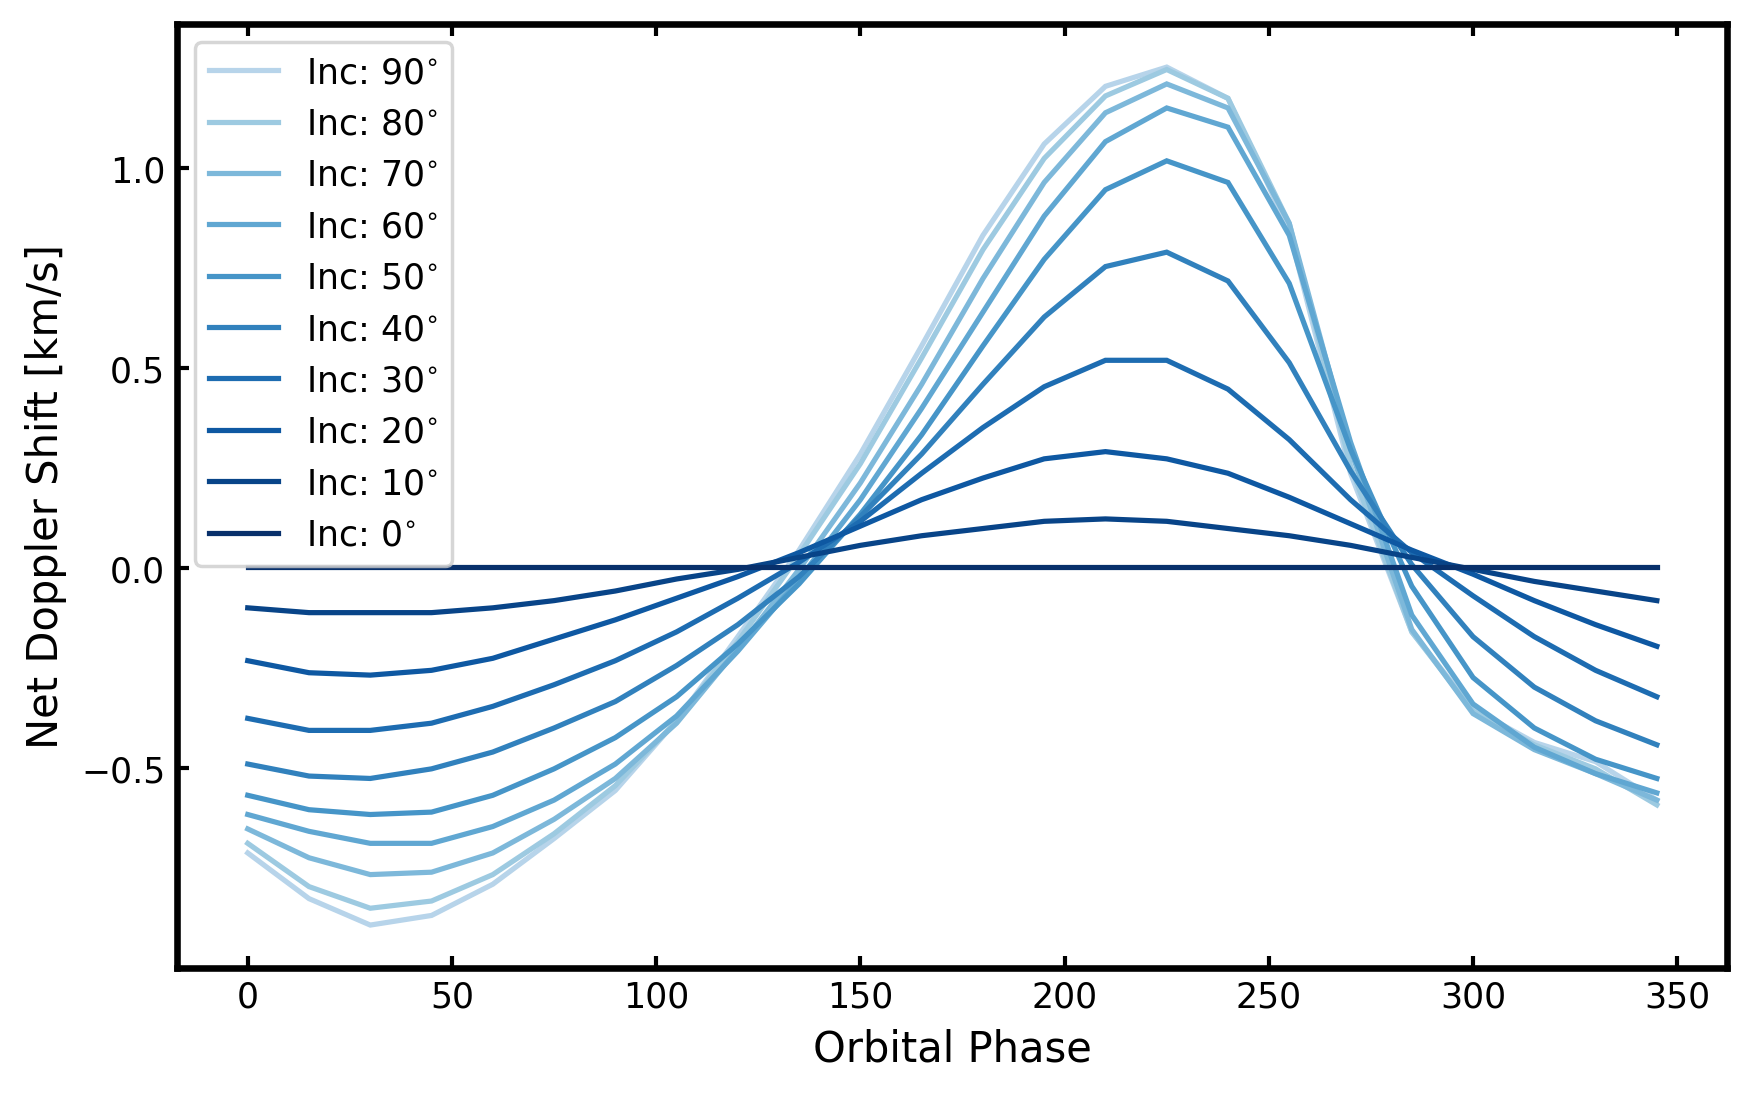

In [58]:
fig, ax = plt.subplots(1, sharex=True, sharey=True,
                       figsize=(8, 5), gridspec_kw={'hspace': 0.15, 'wspace': 0.10})
from scipy.interpolate import interp1d

phases = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0,
         120.0, 135.0, 150.0, 165.0, 180.0, 195.0, 210.0,
         225.0, 240.0, 255.0, 270.0, 285.0, 300.0, 315.0, 330.0, 345.0]

colors = plt.cm.Blues(np.linspace(.3, 1, len(test_dictionary)))


i = 0
for key in test_dictionary:
    inclination = str(90 - (10 * i))
    
    #func_test = interp1d(phases, test_dictionary[key], kind='cubic')
    #new_x = np.linspace(0, 5/6, 100)
    
    #ax.plot(new_x, func_test(new_x), color=colors[i], linestyle='solid', 
    #        linewidth=1.5, label=r'Inc: ' + inclination[:4] + '$^{\circ}$')
    
    ax.plot(phases, test_dictionary[key], color=colors[i], linestyle='solid', 
            linewidth=1.5, label=r'Inc: ' + inclination[:4] + '$^{\circ}$')
    
    i = i + 1

ax.set_ylabel('Net Doppler Shift [km/s]')
ax.set_xlabel('Orbital Phase')
ax.legend()
fig.savefig('/home/imalsky/Desktop/grorobiiiitititi.pdf', dpi=250, bbox_inches='tight')


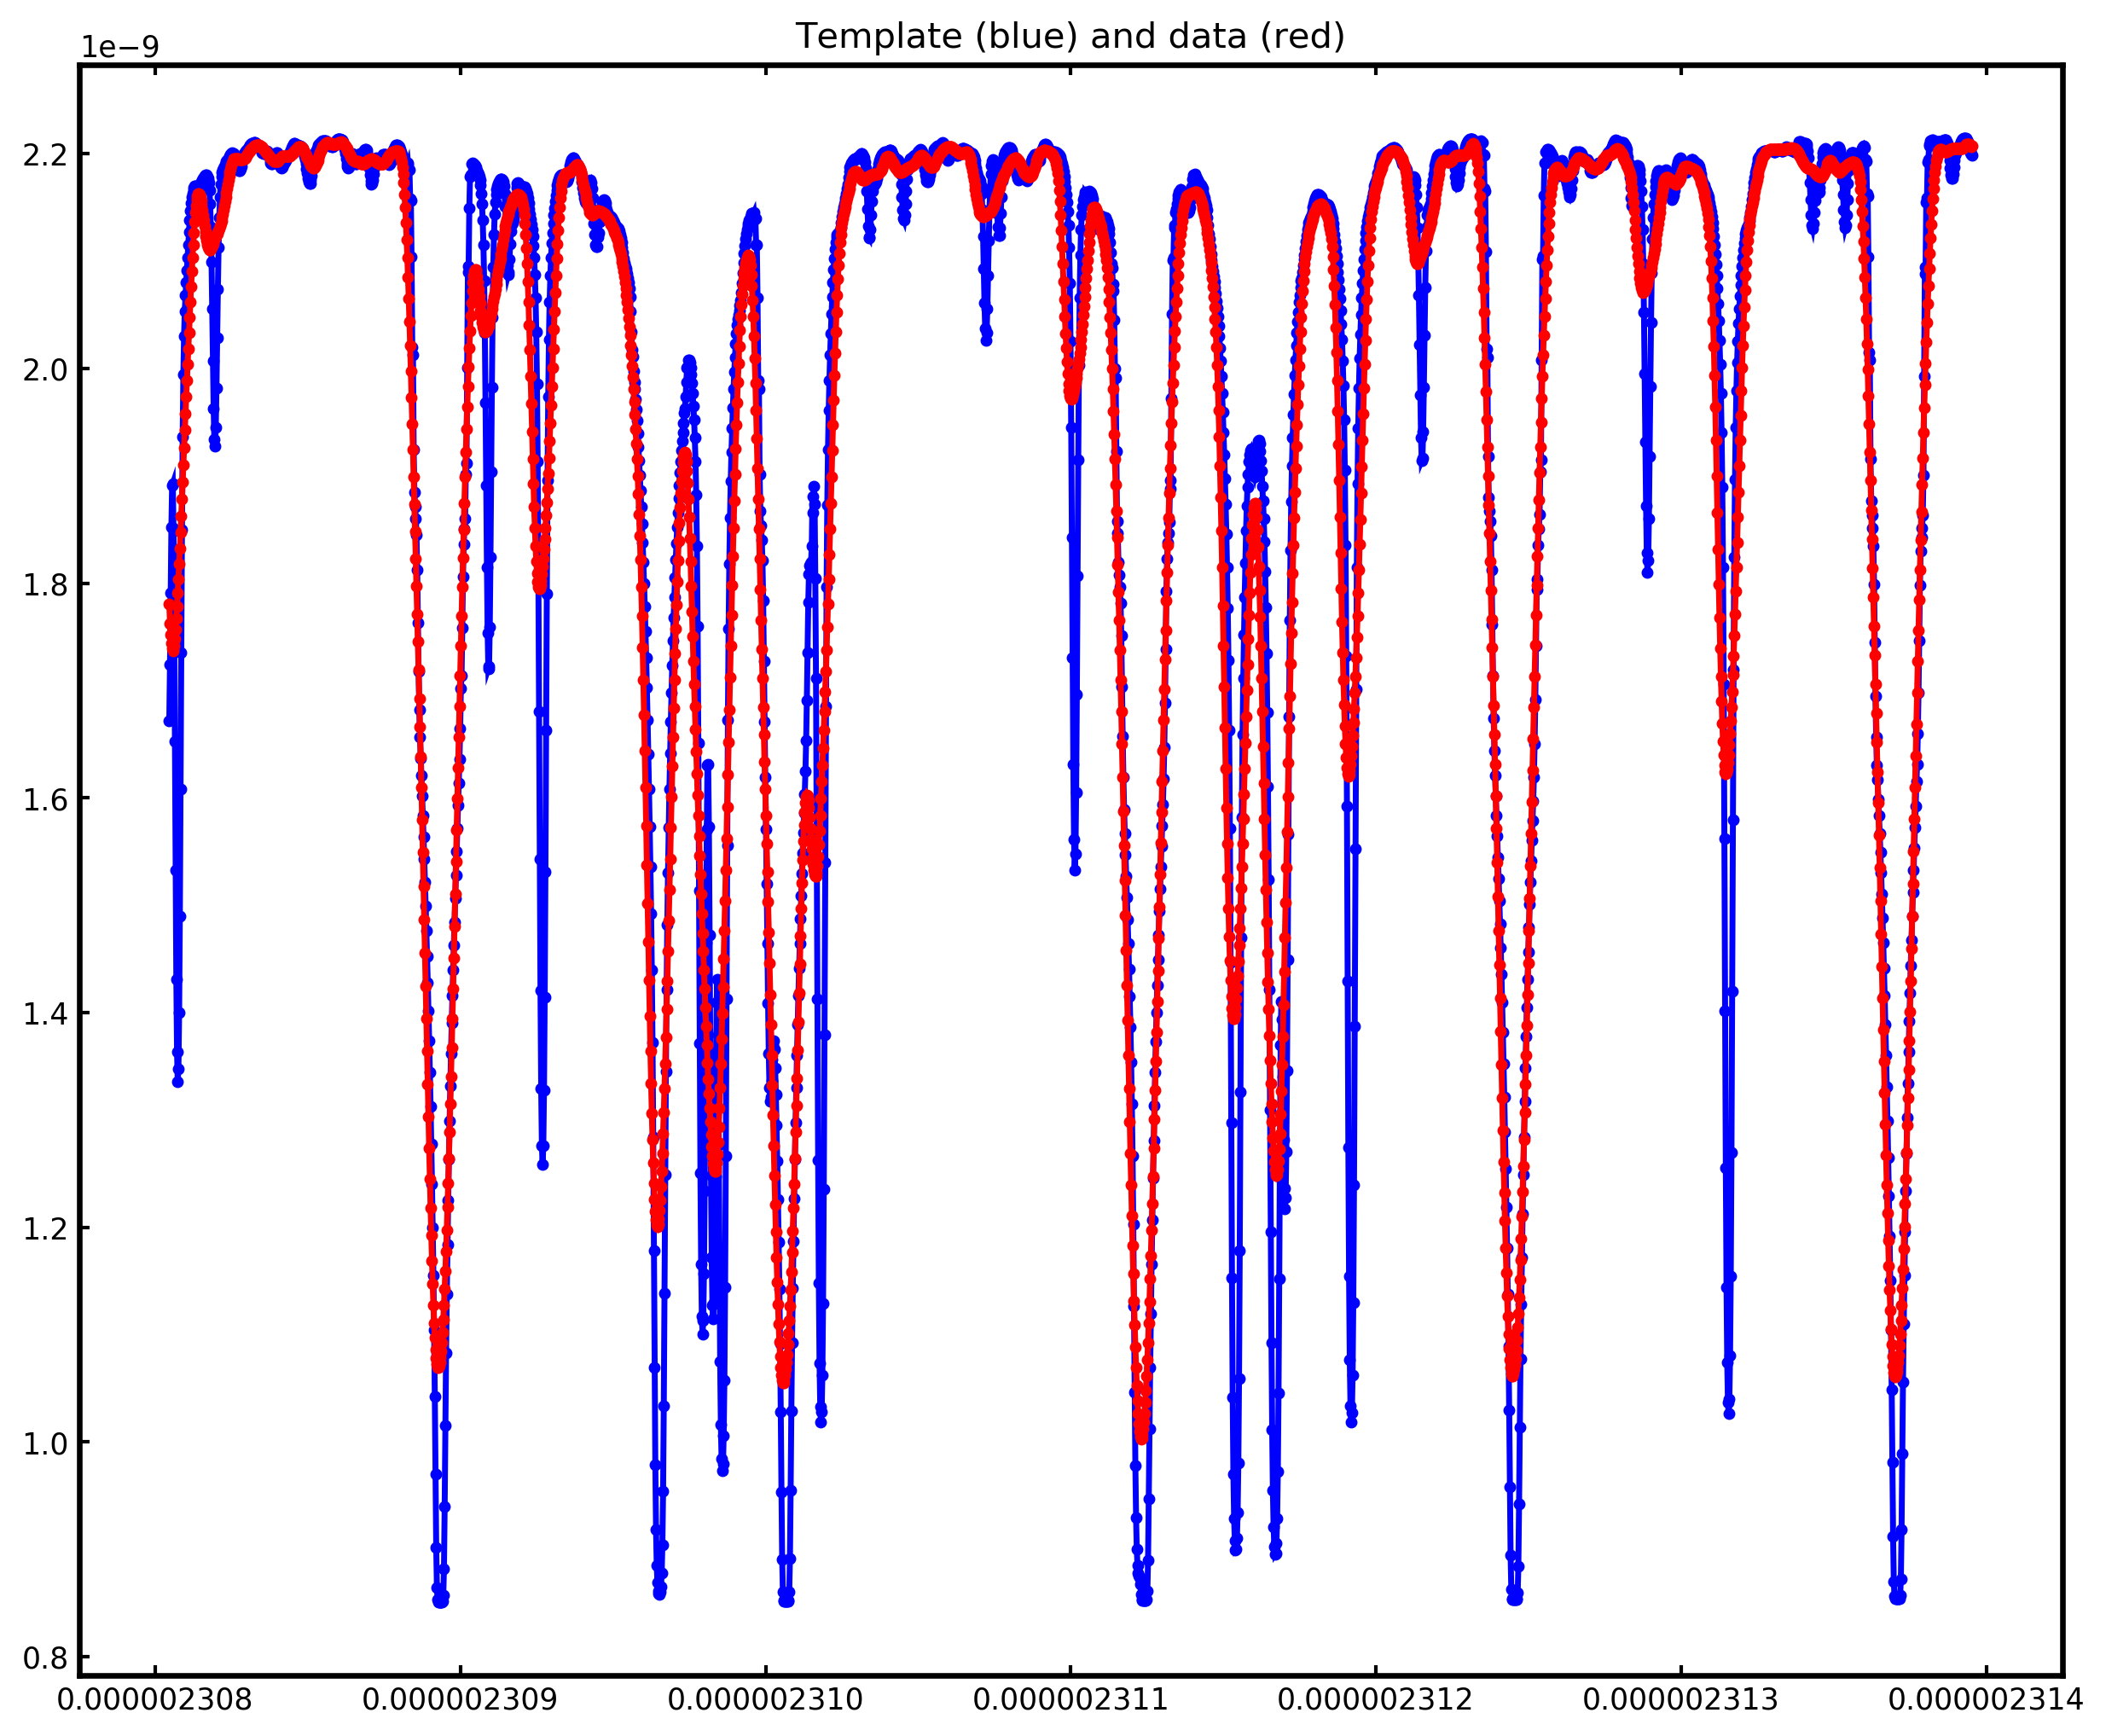

In [29]:
file1 = base + 'Spec_0_UPS-BIG-G-CLEAR-250_phase_{}_inc_{}000.00.dat'.format(phase, inc)
file2 = base + 'Spec_1_UPS-BIG-G-CLEAR-250_phase_{}_inc_{}000.00.dat'.format(phase, inc)
#file3 = base + 'Exo_UpAndB_high_g_2_Final_UpAndB_high_g_phase_{}_inc_{}000.00.dat'.format(phase, inc)
#file4 = base + 'Exo_UpAndB_high_g_3_Final_UpAndB_high_g_phase_{}_inc_{}000.00.dat'.format(phase, inc)

w1, f1 = np.loadtxt(file1, unpack=True)
w2, f2 = np.loadtxt(file2, unpack=True)
#w3, f3 = np.loadtxt(file3, unpack=True)
#w4, f4 = np.loadtxt(file4, unpack=True)

w1 = w1[20:-20]
w2 = w2[20:-20]
f1 = f1[20:-20]
f2 = f2[20:-20]


#rv1, cc1 = pyasl.crosscorrRV(w1, f1, w1[5:-5], f1[5:-5], -30., 30., 30./50., skipedge=20)
#rv2, cc2 = pyasl.crosscorrRV(w2, f2, w1, f1, -15., 15., 1, skipedge=val)


#rv1, cc1 = pyasl.crosscorrRV([1,2,3], [1,2,3], [1,2,3], [1,2,3], -30., 30., 30./50., skipedge=0)


# Plot template and data
plt.title("Template (blue) and data (red)")
plt.plot(w1, f1, 'b.-')
plt.plot(w2, f2, 'r.-')
plt.show()

In [14]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt

# Create the template
tw = np.linspace(5000, 5010, 1000)
tf = np.exp(-(tw-5004.0)**2/(2.*0.1**2))

# Create data, which are not that well sampled
dw = np.linspace(5000, 5010, 200)
df = np.exp(-(dw-5004.17)**2/(2.*0.1**2))

# Plot template and data
plt.title("Template (blue) and data (red)")
plt.plot(tw, tf, 'b.-')
plt.plot(dw, df, 'r.-')
plt.show()

# Carry out the cross-correlation.
# The RV-range is -30 - +30 km/s in steps of 0.6 km/s.
# The first and last 20 points of the data are skipped.
rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -30., 30., 30./50., skipedge=20)
